In [12]:
import pandas as pd
import numpy as np
import matplotlib as plt
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad

In [13]:
sc.settings.verbosity = 3            
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.17.4 scipy==1.7.3 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.5


In [14]:
# reading data

# biospsy tissue samples, endometrium
adata_ti = sc.read_h5ad(
            "/home/vfs/PycharmProjects/Organoids_sc_WS2122/data/Garcia_Alonso_tissue/GarciaAlsonso_tissue_subsampled.h5ad")
adata_ti.var_names_make_unique()

In [15]:
# endometrial organoids, 1 donor 

adata_org = sc.read_h5ad(
            "/home/vfs/PycharmProjects/Organoids_sc_WS2122/data/Garcia_Alonso_tissue/GarciaAlsonso_organoid_subsampled.h5ad"
)
adata_org.var_names_make_unique()

## Objective: Do endometerial organoid cell types resemble the tissue cell types? 

## Analysis steps:  
### Tissue
* sample clustering and check for merge possibility 
    - PCA plot
    - UMAP (all samples, sample wise coloring)
    - UMAP after samples -> check if mergeable
* merge samples
    - UMAP for confirmation again
* subsample for epithila cell types bc those are the once we expect in organoids too
* cluster/UMAP again

### Organoids 
* sample clustering and check for merge possibility 
    - PCA plot
    - UMAP 
    - UMAP after samples -> check if mergeable
* merge samples

## Downstream analysis: 
* plot with proportion number of cells per cell type (?)
* correlation between increase of certain cell type in tissue and organoids

### Tissue: sample clustering and check for merge possibility

In [16]:
# PCA 
sc.tl.pca(adata_ti, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_ti, log=True)

computing PCA
    with n_comps=50


KeyboardInterrupt: 

The ellbow starts to flatten with 31 PCs. One could calculate more. However, the comparabily low detail of the celltype
labeling indicates that this is not necessary.

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:57)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


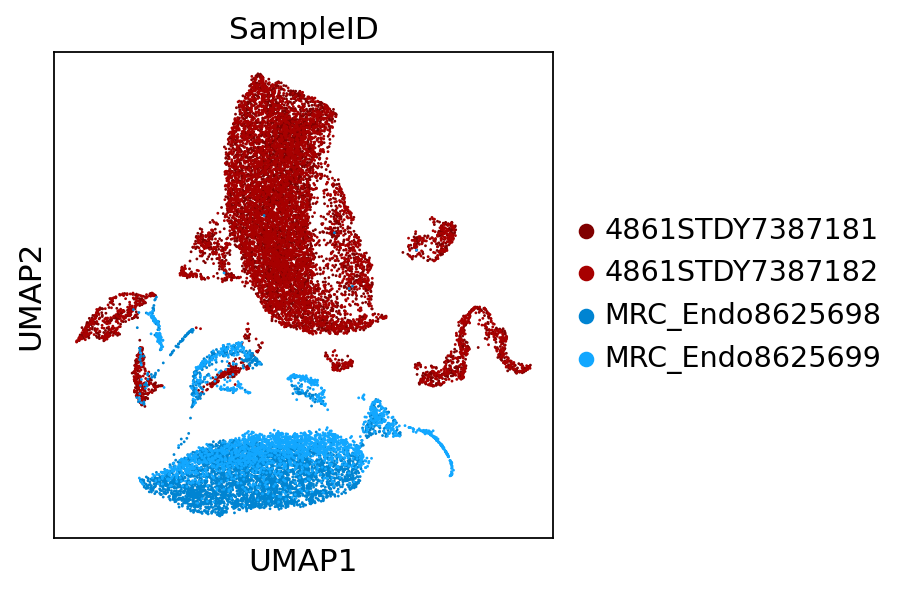

In [17]:
# UMAP all samples

sc.pp.neighbors(adata_ti, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata_ti)

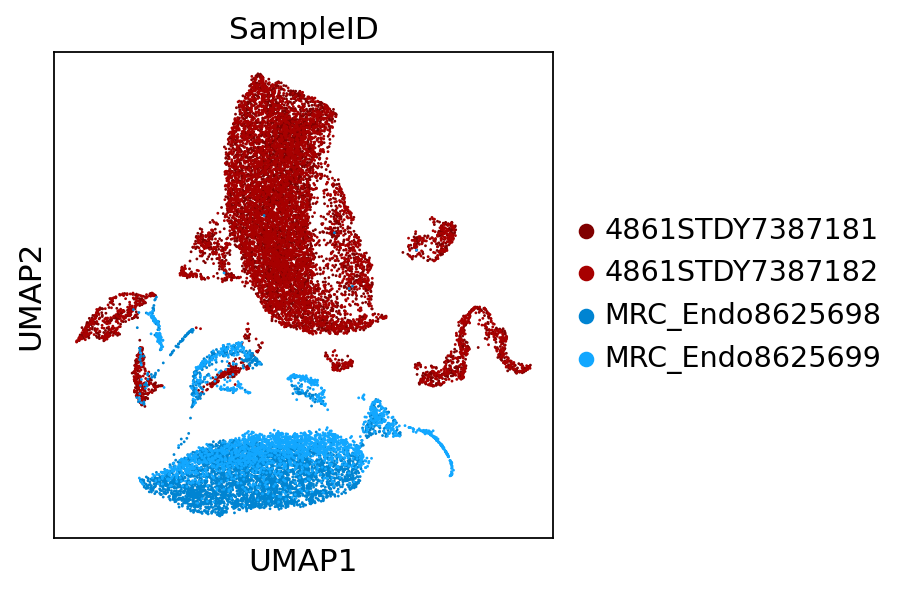

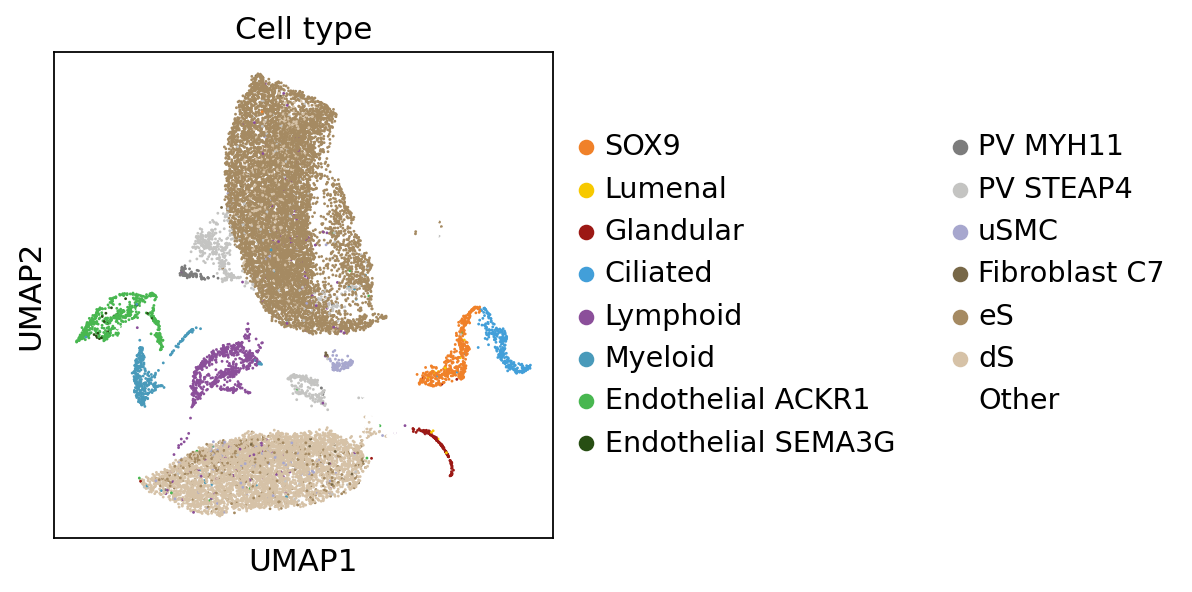

In [18]:
sc.pl.umap(adata_ti, color="SampleID")
sc.pl.umap(adata_ti, color="Cell type")


Those UMAPs indicate that the two samples from each state could be merged together. (Why? elaborate)

In [20]:
# enabel sample wise analysis
adata_ti_pro_1 = adata_ti[adata_ti.obs["SampleID"] == "4861STDY7387181", :]  #pro sample 1
adata_ti_pro_2 = adata_ti[adata_ti.obs["SampleID"] == "4861STDY7387182", :]  #pro sample 2
adata_ti_sec_1 = adata_ti[adata_ti.obs["SampleID"] == "MRC_Endo8625698", :]  #sec sample 1
adata_ti_sec_2 = adata_ti[adata_ti.obs["SampleID"] == "MRC_Endo8625699", :]  #sec sample 2

# merging both proliferating phase sample, and both secretory stage samples
adata_ti_merged_proliferative = ad.concat([adata_ti_pro_1,adata_ti_pro_2], join="outer")
adata_ti_merged_secretory = ad.concat([adata_ti_sec_1,adata_ti_sec_2], join="outer")

data_list_merged_ti = [adata_ti_merged_proliferative, adata_ti_merged_secretory]

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


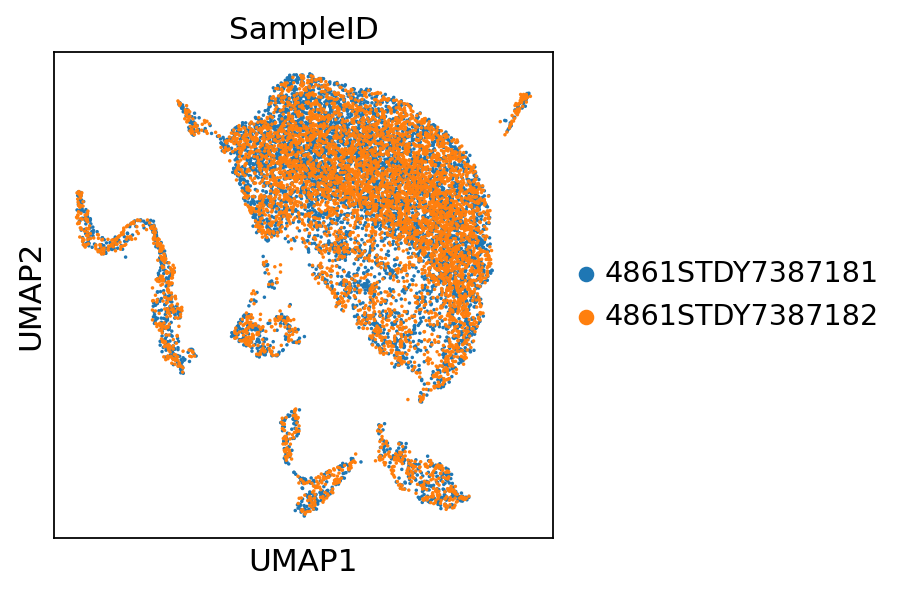

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


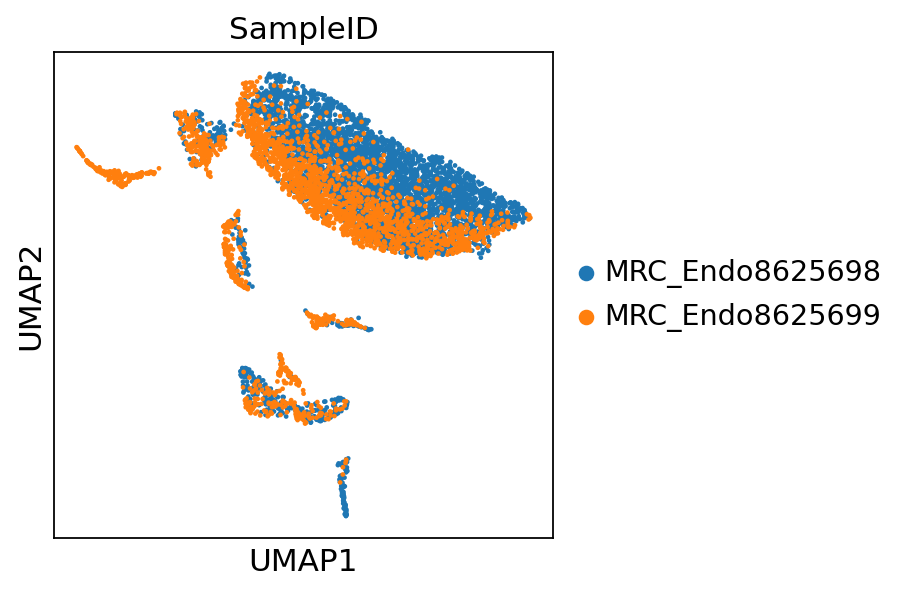

In [23]:
# UMAP per men.cycle stage
for item in data_list_merged_ti:
    sc.pp.neighbors(item, n_neighbors=10, n_pcs=30)
    sc.tl.umap(item)

In [ ]:
for item in data_list_merged_ti:
    sc.pl.umap(item, color="SampleID")

the two samples cluster together very good. No data integration is needed.

Now we check for cell types similarities between the phases

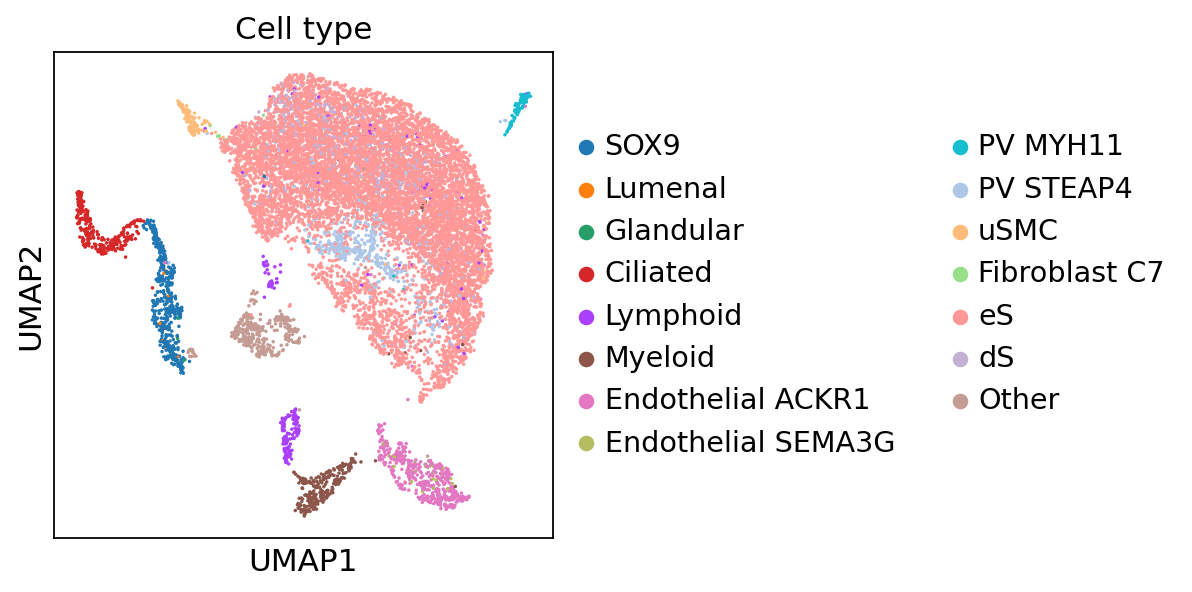

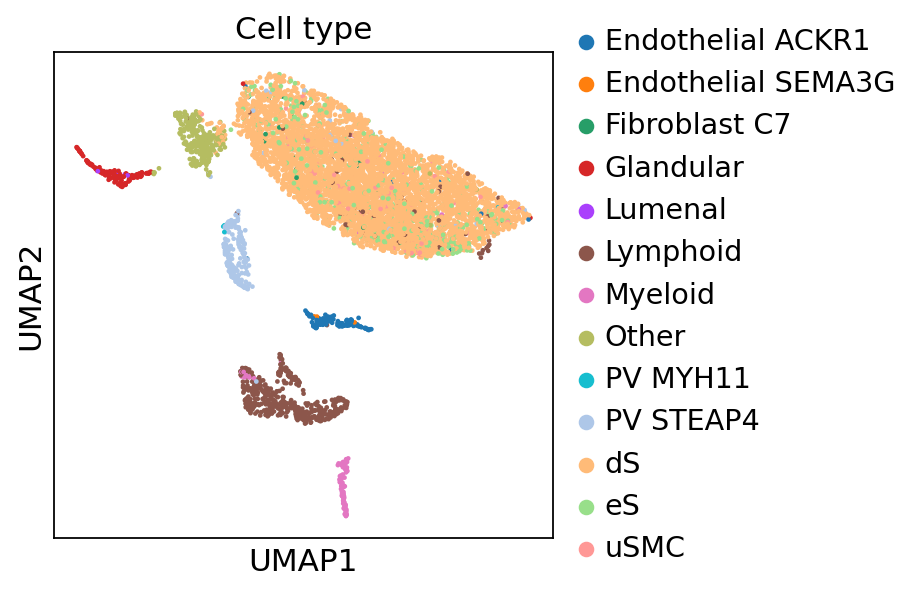

In [25]:
# UMAP for cell types
for item in data_list_merged_ti:
    sc.pl.umap(item, color="Cell type") # TODO force color on cell type, for comparability of both plots

Since in organoids we will only expect epithelia cell types we subsample the tissue samples for epithila cell types
only too. Taken from [the paper](link to mapping paper) the epithelia cell types are:  Lumen, Gland, SOX9,

In [26]:
adata_ti.obs

,SampleID,log2p1_count,percent_mito,n_genes,DonorID,BiopsyType,Location,Binary Stage,Stage,Broad cell type,Cell type,CellCycle Phase
4861STDY7387181_AAACCTGAGGCATGGT,4861STDY7387181,13.951467,0.057320,3842,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,eS,S
4861STDY7387181_AAACCTGAGGGCACTA,4861STDY7387181,13.776227,0.043838,3544,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,eS,G1
4861STDY7387181_AAACCTGAGTGAAGTT,4861STDY7387181,12.894628,0.070791,2507,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Supporting,PV STEAP4,G1
4861STDY7387181_AAACCTGAGTGGGCTA,4861STDY7387181,12.329235,0.071137,1928,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,dS,G1
4861STDY7387181_AAACCTGCACCGAAAG,4861STDY7387181,12.171176,0.063977,1824,A13,Organ_Donor,endometrium_enriched,Proliferative,proliferative,Stromal,eS,G1
...,...,...,...,...,...,...,...,...,...,...,...,...
MRC_Endo8625699_TTTGGAGGTAACGATA,MRC_Endo8625699,12.696532,0.005876,1784,E1,Superficial_Biopsy,endometrium_biopsy,Secretory,late-secretory,Excluded,Other,G1
MRC_Endo8625699_TTTGGTTAGATACCAA,MRC_Endo8625699,13.761448,0.092179,3166,E1,Superficial_Biopsy,endometrium_biopsy,Secretory,late-secretory,Stromal,dS,G1
MRC_Endo8625699_TTTGGTTAGCATATGA,MRC_Endo8625699,14.286557,0.074063,4024,E1,Superficial_Biopsy,endometrium_biopsy,Secretory,late-secretory,Stromal,dS,G1
MRC_Endo8625699_TTTGGTTAGTATGGAT,MRC_Endo8625699,13.192447,0.133440,2809,E1,Superficial_Biopsy,endometrium_biopsy,Secretory,late-secretory,Stromal,eS,G1


In [ ]:
# subsampling tissue for epithelia cells

adata_ti


In order to get a feeling if the amount of cells of certain cell types have changed across the cycle we analysed
proportional changes of cell counts per cell type between both states.

1. get total cell number per sample (tissue-prolif, tissue-secre, organoid-cntlr, organoid-E2 treated)
2. get cell number per cell type
3. get proportion per cell type
4. indicate increase or decrease over time

## Objective: Does the cycle state of the donor influence the organoid?

### Analysis steps: 
* looking for gene marker specific for proliferative phase (endothelia cells only)
    - Table with differentially expressed genes in tissue
* check for cycle-state specificity
    - heatmap comparing proliferative tissue & secretory tissue
    - heatmap scaled and normalized
* check for transferablilty to organoids (Day0  and Day6)
    - heatmap with prolif, secretory tissue + day0, day6 organoids
    - saled and normalized 